In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, roc_auc_score, recall_score, precision_score, accuracy_score, mean_squared_error, auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import pickle
import csv
from imblearn.over_sampling import SMOTE
import dimod
import json
from sklearn import preprocessing
from copy import deepcopy
from matplotlib import colors


In [2]:
# define directory structure
models_dir = "models"
models_evaluation_dir = "models_evaluation"
plots_dir = "plots"
extended_model_base_dir = os.path.join(models_dir, "extended_models")
extended_model_evaluation_base_dir = os.path.join(models_evaluation_dir, "extended_models")
condensed_model_base_dir = os.path.join(models_dir, "condensed_models")
condensed_model_evaluation_base_dir = os.path.join(models_evaluation_dir, "condensed_models")
p_matrix_base_dir = os.path.join(models_evaluation_dir, "p_matrix")
p_matrix_plot_base_dir = os.path.join(plots_dir,"p_matrix")

In [4]:
df_all = pd.read_csv("data/med_orginal2.csv",header=0, sep="\,").fillna(method = "ffill")


target_f = 'Graft loss 1 year'

mandatory_f = [
    'AKI - KDIGO 2012',
    'FSGS',
    'Reduction to steroid only',
    'Transfusion [YES/NO]',
]

with open("data/16.json") as file:
    miqubo_result = dimod.SampleSet.from_serializable(json.load(file))
    miqubo_f = [x for x, y in miqubo_result.first.sample.items() if y ==1]

miqubo_f = list(set(miqubo_f) - set(mandatory_f) - set(target_f))
assert sum(df_all.isna().sum())==0, "Still nan entries in dataset"

df_ = deepcopy(df_all)
naming_map_ = {x[1] : "f_{}".format(x[0]) for x in enumerate(df_.columns)}
df_ = df_.rename(columns=naming_map_)
target_f = naming_map_[target_f]
mandatory_f = [naming_map_[x] for x in mandatory_f]
free_f_miqubo = [naming_map_[x] for x in miqubo_f]
free_f_all_ = list(set(naming_map_.values()) - set(mandatory_f) - set(target_f))

# get raw dataset
df_all = df_all.rename(columns = naming_map_)
df_miqubo = df_all[[target_f] + mandatory_f + free_f_miqubo]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [5]:
def normalize_dataset(df): 
    binary_f = [x for x in df.columns if len(np.unique(df[x]))==2]
    float_f = list(set([x for x, y in df.dtypes.items() if y == np.float]) - set(binary_f))
    int_f = list(set([x for x, y in df.dtypes.items() if y == np.int]) - set(binary_f))

    df_float_norm = pd.DataFrame(data=preprocessing.StandardScaler().fit(df[float_f]).transform(df[float_f]), columns=float_f)
    df_int_norm = pd.DataFrame(data=preprocessing.StandardScaler().fit(df[int_f]).transform(df[int_f]), columns=int_f)
    return pd.concat([df[binary_f], df_float_norm, df_int_norm], axis=1, join="inner")

def sample_dataset(df, target_f):
    # get normalized dataset
    y_train = df.pop(target_f)
    x_train = df

    # get normalized and sampled dataset
    df_sampled, label_sampled = SMOTE().fit_resample(x_train, y_train)
    df_sampled.insert(0, target_f, label_sampled)
    return df_sampled

def transform_dataset(df, target_f = target_f, miqubo = False, normalized=False, sampled=False):
    df_ = deepcopy(df)
    if normalized:
        df_ = normalize_dataset(df_)
    if sampled:
        df_ = sample_dataset(df_, target_f)

    y_train = df_.pop(target_f)
    x_train = df_
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)
    return {
        "x_train" : x_train, 
        "y_train" : y_train, 
        "x_test" : x_test, 
        "y_test" : y_test, 
        "miqubo": miqubo, 
        "normalized" : normalized,
        "sampled" : sampled}
   
raw_all     = transform_dataset(df_all,    target_f, miqubo = False, normalized = False, sampled=False)
s_all       = transform_dataset(df_all,    target_f, miqubo = False, normalized = False, sampled=True)
n_all       = transform_dataset(df_all,    target_f, miqubo = False, normalized = True,  sampled=False)
sn_all      = transform_dataset(df_all,    target_f, miqubo = False, normalized = True,  sampled=True)
raw_miqubo  = transform_dataset(df_miqubo, target_f, miqubo = True,  normalized = False, sampled=False)
s_miqubo    = transform_dataset(df_miqubo, target_f, miqubo = True,  normalized = False, sampled=True)
n_miqubo    = transform_dataset(df_miqubo, target_f, miqubo = True,  normalized = True,  sampled=False)
ns_miqubo   = transform_dataset(df_miqubo, target_f, miqubo = True,  normalized = True,  sampled=True) 

In [6]:
def train_models(models, models_names, x_train, y_train, x_test, y_test, miqubo, normalized, sampled):
    miqubo_label = "miqubo" if miqubo else "all"
    model_save_dir = "raw"
    if sampled:
        if normalized: 
            model_save_dir = "sampled_normalized"
        else:
            model_save_dir = "sampled"
    else:
        if normalized:
            model_save_dir = "normalized"
    try: 
        os.mkdir(os.path.join(models_dir, model_save_dir)) 
    except OSError as error: 
        print(error) 

    try: 
        os.mkdir(os.path.join(models_evaluation_dir, model_save_dir)) 
    except OSError as error: 
        print(error) 
    trained_models = {}
    threashold = 0.9

    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    for model, model_name in zip(models, models_names):
        # evaluate model
        scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
        
        model.fit(x_train, y_train)
        model_path = os.path.join(models_dir, model_save_dir, '{}_{}.joblib'.format(model_name, miqubo_label))
        pickle.dump(
            model, 
            open(model_path, 'wb')
            )
        # discretize predictions
        y_pred = np.where(model.predict(x_test)>threashold,1, 0)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred) 
        precission = precision_score(y_test, y_pred) 
        accuracy = accuracy_score(y_test, y_pred)

        fpr, tpr, thresholds = roc_curve(y_test, model.predict(x_test))

        # add model to dictionary
        trained_models[model_name] = {}
        trained_models[model_name]["model"] = model
        trained_models[model_name]["name"] = model_name
        trained_models[model_name]["pred"] = model.predict(x_test)
        trained_models[model_name]["predT"] =y_pred
        trained_models[model_name]["mse"] = mse
        trained_models[model_name]["r2"] = r2
        trained_models[model_name]["roc"] = roc
        trained_models[model_name]["recall"] = recall
        trained_models[model_name]["precission"] = precission
        trained_models[model_name]["accurarcy"] = accuracy
        trained_models[model_name]["fpr"] = fpr
        trained_models[model_name]["tpr"] = tpr 
        trained_models[model_name]["thresholds"] = thresholds

        # summarize performance
        #print('Mean ROC AUC: %.3f' % mean(scores))
        #print("Name: {} | ROC: {}, recall: {}, precission: {}, accuracy: {}".format(name, roc, recall, precission, accuracy))

    with open(os.path.join(
        models_evaluation_dir, model_save_dir,
        '{}.csv'.format(miqubo_label)), 
        'w', encoding='UTF8') as f:
        # create the csv writer
        writer = csv.writer(f)

        # write the header
        writer.writerow(['name', 'mse', 'r2', 'roc', 'recall', 'precission', 'accurarcy'])

        for model in trained_models:
            model_evaluation = trained_models[model]
            row = [
                model_evaluation['name'],
                model_evaluation['mse'],
                model_evaluation['r2'],
                model_evaluation['roc'],
                model_evaluation['recall'],
                model_evaluation['precission'],
                model_evaluation['accurarcy'],
            ]
            # write the data
            writer.writerow(row)

    return trained_models

In [7]:
models_names = ["Lasso", "Enet", "Loger", "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
        "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
        "Naive Bayes", "QDA"]
alpha = 0.01
models = [
    linear_model.Lasso(alpha=alpha, normalize = False),
    linear_model.ElasticNet(alpha=alpha, l1_ratio=0.7, normalize = False),
    LogisticRegression(solver='lbfgs', class_weight={x:y for x, y in zip(np.unique(df_all[target_f]), np.bincount(df_all[target_f]))}),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

all_models                          = train_models(models, models_names, **raw_all)
all_models_sampled                  = train_models(models, models_names, **s_all)
all_models_normalized               = train_models(models, models_names, **n_all)
all_models_sampled_normalized       = train_models(models, models_names, **sn_all)
miqubo_models_sampled               = train_models(models, models_names, **raw_miqubo)
miqubo_models                       = train_models(models, models_names, **s_miqubo)
miqubo_models_normalized            = train_models(models, models_names, **n_miqubo)
miqubo_models_sampled_normalized    = train_models(models, models_names, **ns_miqubo)

[Errno 17] File exists: 'models/raw'
[Errno 17] File exists: 'models_evaluation/raw'


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use 

[Errno 17] File exists: 'models/sampled'
[Errno 17] File exists: 'models_evaluation/sampled'


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[Errno 17] File exists: 'models/normalized'
[Errno 17] File exists: 'models_evaluation/normalized'


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn(

[Errno 17] File exists: 'models/sampled_normalized'
[Errno 17] File exists: 'models_evaluation/sampled_normalized'


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[Errno 17] File exists: 'models/raw'
[Errno 17] File exists: 'models_evaluation/raw'


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

[Errno 17] File exists: 'models/sampled'
[Errno 17] File exists: 'models_evaluation/sampled'


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Errno 17] File exists: 'models/normalized'
[Errno 17] File exists: 'models_evaluation/normalized'


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined a

[Errno 17] File exists: 'models/sampled_normalized'
[Errno 17] File exists: 'models_evaluation/sampled_normalized'


In [34]:
def tmp(**kwargs):
    print(kwargs.keys())
tmp(**raw_all)


dict_keys(['x_train', 'y_train', 'x_test', 'y_test', 'miqubo', 'normalized', 'sampled'])


In [103]:
def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])

def kernel(X, Y):
    return .5 if Y==X else int(Y < X)

def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    
def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])

def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    try:
        return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))
    except:
        return 1.0

# Model A (random) vs. "good" model B
#preds_A = np.array([.5, .5, .5, .5, .5, .5, .5, .5, .5, .5])
#preds_B = np.array([.2, .5, .1, .4, .9, .8, .7, .5, .9, .8])
#actual= np.array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1])

def group_preds_by_label(preds, actual):
    X = [p for (p, a) in zip(preds, actual) if a]
    Y = [p for (p, a) in zip(preds, actual) if not a]
    return X, Y

def get_p_value(preds_A, preds_B, actual_A, actual_B):
    X_A, Y_A = group_preds_by_label(preds_A, actual_A)
    X_B, Y_B = group_preds_by_label(preds_B, actual_B)
    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)
    auc_A = auc(X_A, Y_A)
    auc_B = auc(X_B, Y_B)
    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
            + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
            + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))
    # Two tailed test
    z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
    p = st.norm.sf(abs(z))*2
    return p


In [124]:
def get_p_matrix(a_models, b_models, 
                a_x_train, a_y_train, a_x_test, a_y_test, a_miqubo, a_normalized, a_sampled, 
                b_x_train, b_y_train, b_x_test, b_y_test, b_miqubo, b_normalized, b_sampled):
    
    label_a = "Miqubo" if a_miqubo else "All"
    label_a += " features trained over "
    
    if a_sampled:
        if a_normalized: 
            label_a += "sampled and normalized"
        else:
            label_a += "sampled"
    else:
        if a_normalized:
            label_a += "normalized"
        else:
            label_a += "raw"
    label_a += " dataset"
    
    label_b = "Miqubo" if b_miqubo else "All"
    label_b += " features trained over "
    
    if b_sampled:
        if b_normalized: 
            label_b += "sampled and normalized"
        else:
            label_b += "sampled"
    else:
        if b_normalized:
            label_b += "normalized"
        else:
            label_b += "raw"
    label_b += " dataset"

    file_name = ("MIQUBO" if a_miqubo else "ALL") + "_" + ("" if a_sampled else "non-") + "sampled_" + ("" if a_normalized else "non-") + "normalized_VS_" + ("MIQUBO" if b_miqubo else "ALL") + "_" + ("" if b_sampled else "non-") + "sampled_" + ("" if b_normalized else "non-") + "normalized.csv"
    p_matrix = np.zeros((len(a_models), len(a_models)))
    for row, model_A in enumerate(a_models):
        for col, model_B in enumerate(b_models):
            p_matrix[row][col] = get_p_value(
                a_models[model_A]["predT"], 
                b_models[model_B]["predT"], 
                a_y_test, b_y_test)
    
    # save p_matrix to csv
    np.savetxt(os.path.join(p_matrix_base_dir, file_name), p_matrix, delimiter = ',')

    # save
    plot_p_matrix(
    p_matrix, 
    a_models,
    "P-value matrix - models performance comparison",
    label_a,
    label_b,
    file_name,
    )

    return p_matrix

In [122]:
def plot_p_matrix(p_matrix, model_dict, title, label_x, label_y, file_name, show = False):
    labels = list(model_dict.keys())
    x = np.arange(len(labels))  # the label locations

    mask = np.zeros((len(labels), len(labels)), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    cmap = colors.ListedColormap(['tab:green', 'tab:red'])
    bounds=[0,0.05,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = False
    lower_traingle_p_matrix = np.ma.array(p_matrix, mask = mask)

    fig, ax = plt.subplots(figsize=(12, 12))
    #cmap = 'jet'
    rects1 = ax.imshow(lower_traingle_p_matrix, cmap = cmap, norm=norm)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(title, fontsize=26)
    ax.set_xticks(x)
    ax.set_xlabel(label_x, fontsize=18)
    ax.set_yticks(x)
    ax.set_ylabel(label_y, fontsize=18, rotation = -90)
    ax.set_xticklabels(labels, fontsize=16)
    ax.set_yticklabels(labels, fontsize=16)
    ax.xaxis.set_label_position("top")
    ax.yaxis.set_label_position("right")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    fig.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            if j > i:
                break
            text = ax.text(j, i, "%.3f" % p_matrix[i, j],
                        ha="center", va="center", color="black", weight='bold')
    plot_file_name_png = os.path.join(p_matrix_plot_base_dir, file_name+".png")
    plot_file_name_jpg = os.path.join(p_matrix_plot_base_dir, file_name+".jpg")
    plt.savefig(plot_file_name_png)
    plt.savefig(plot_file_name_jpg)
    if show: 
        plt.show()
    

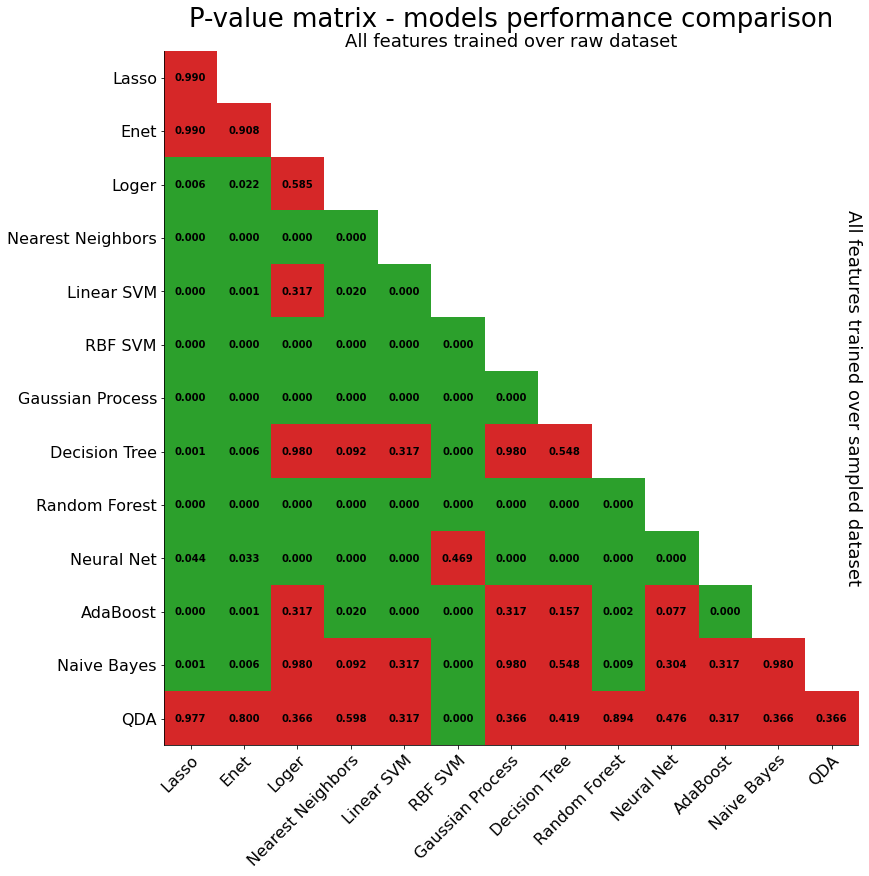

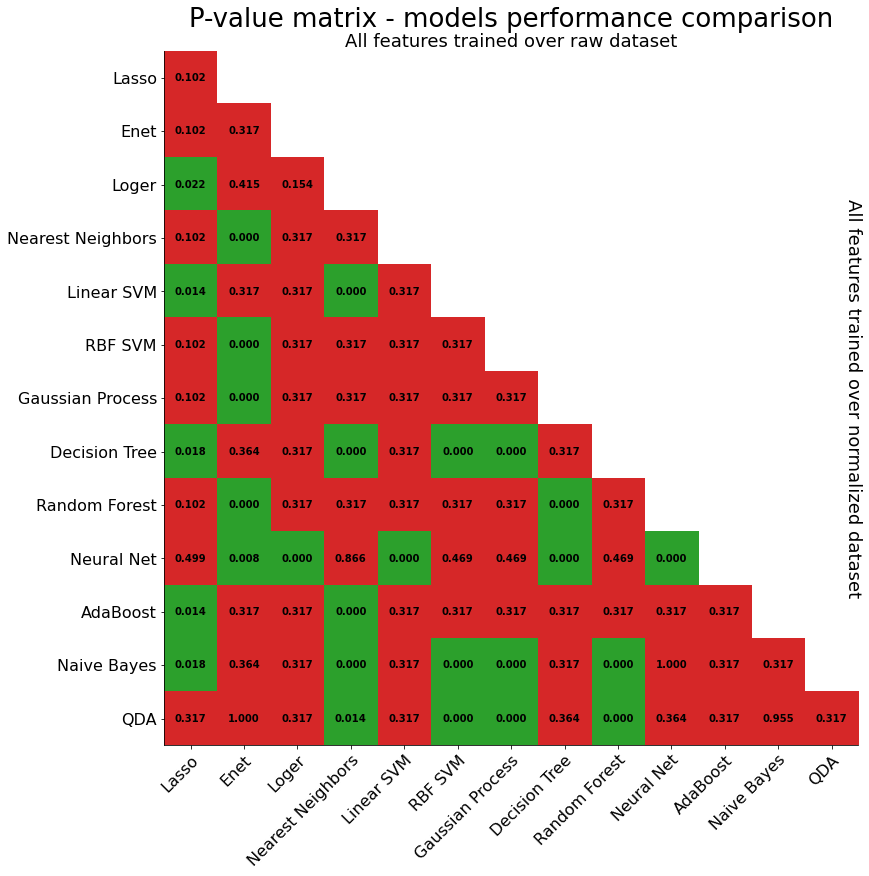

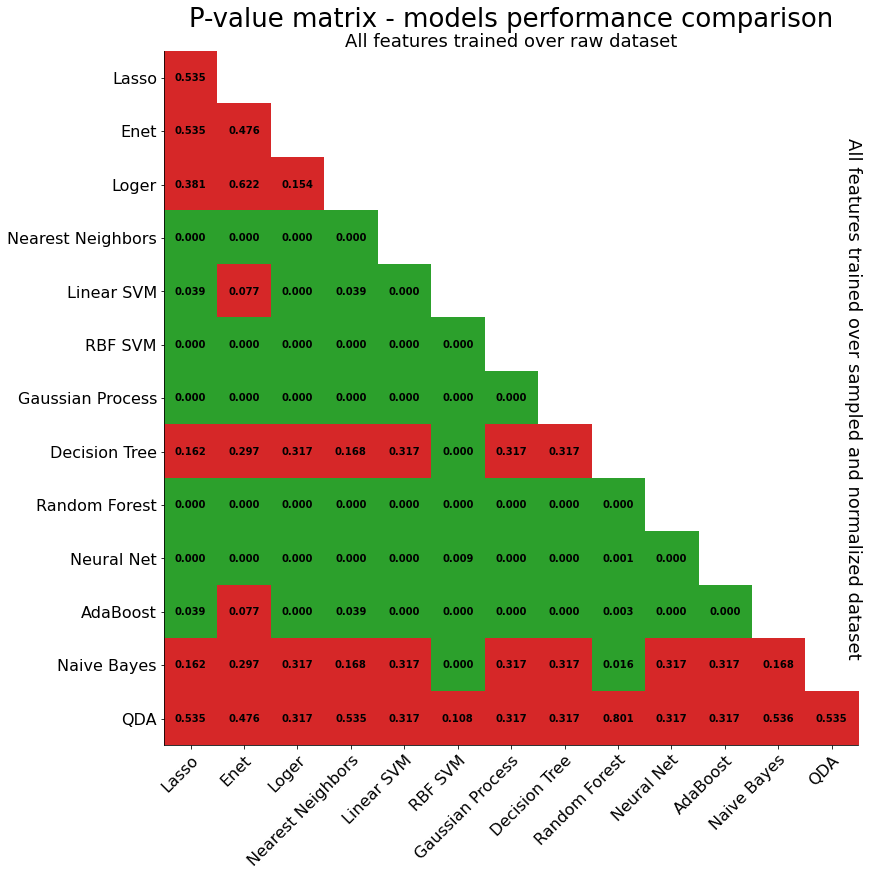

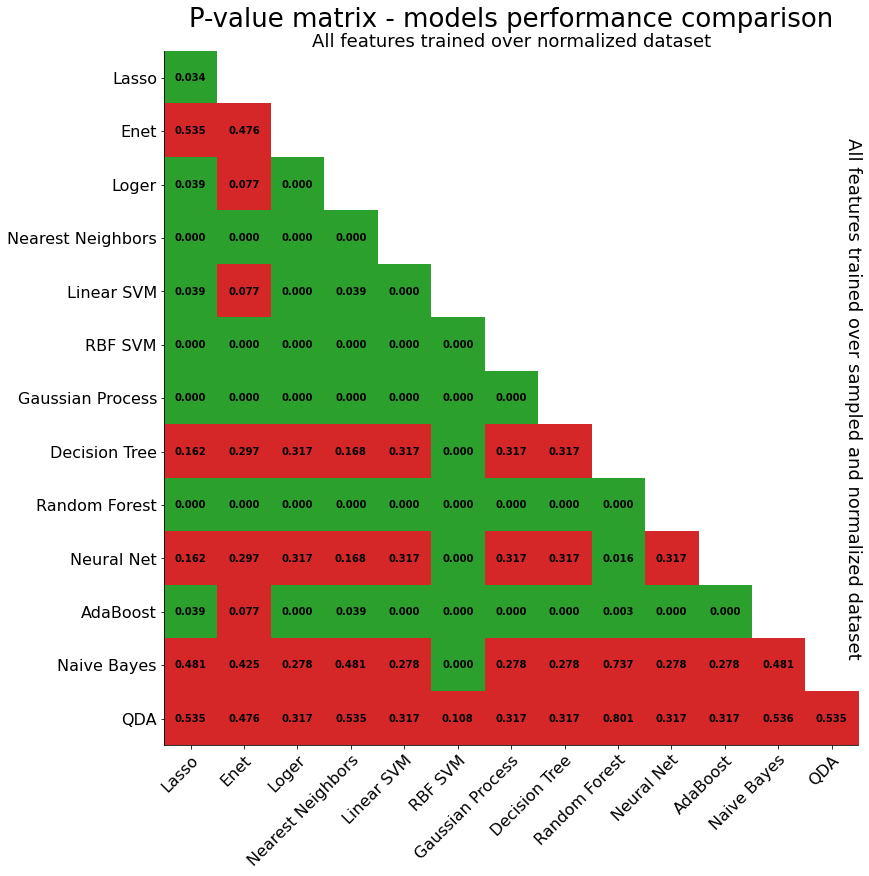

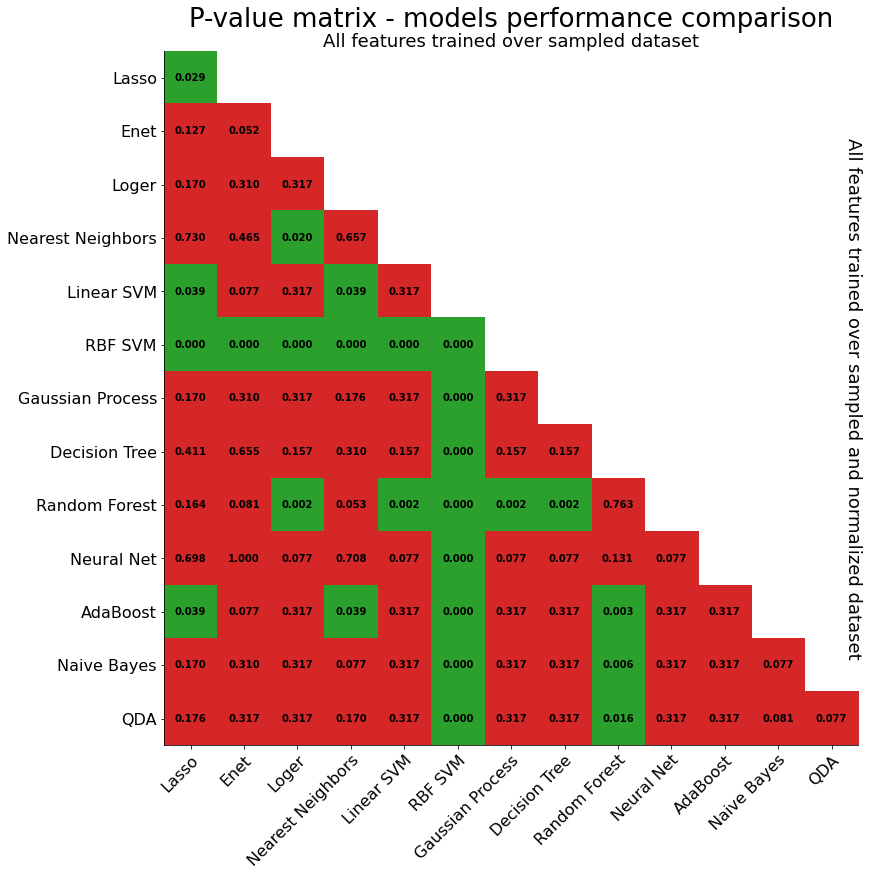

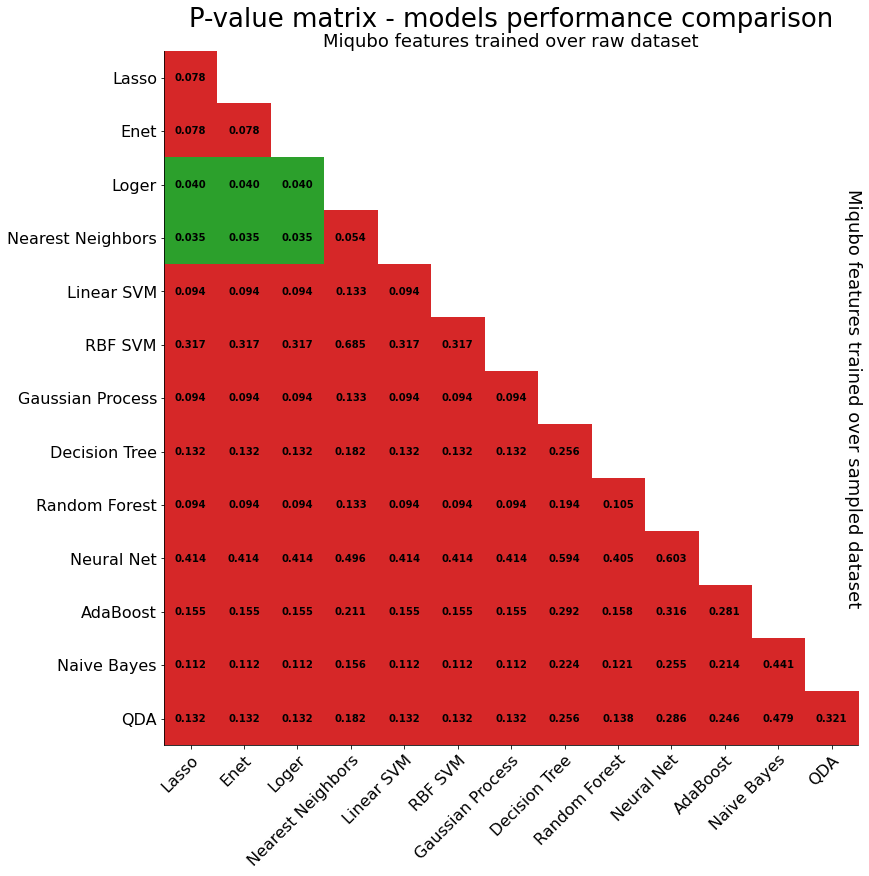

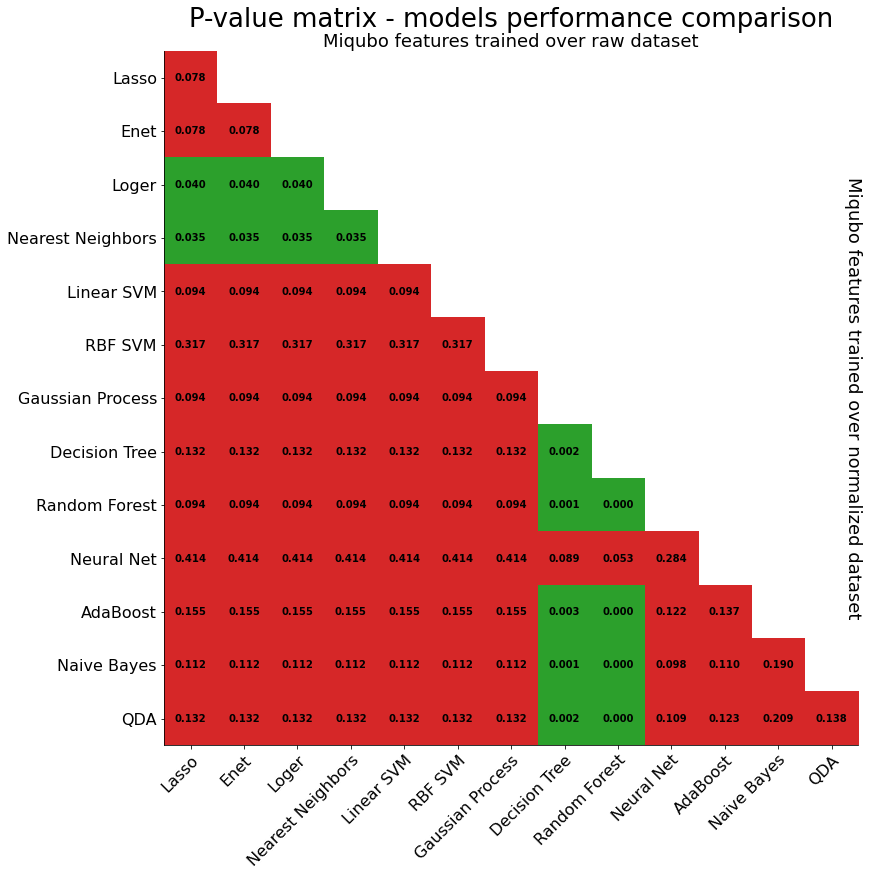

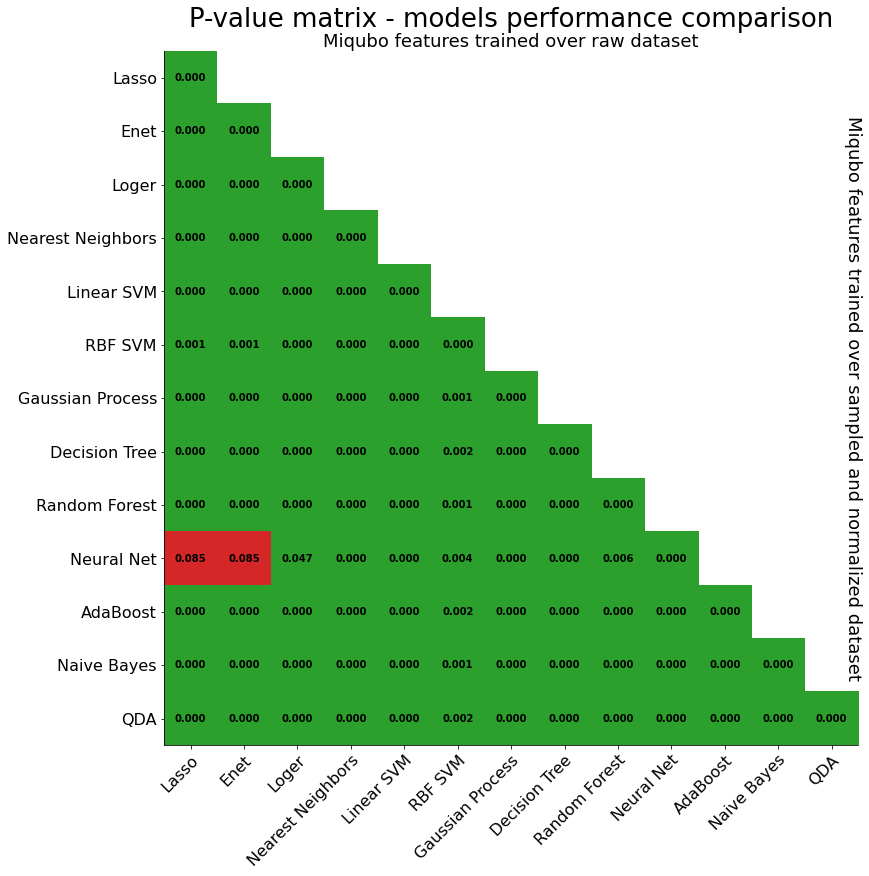

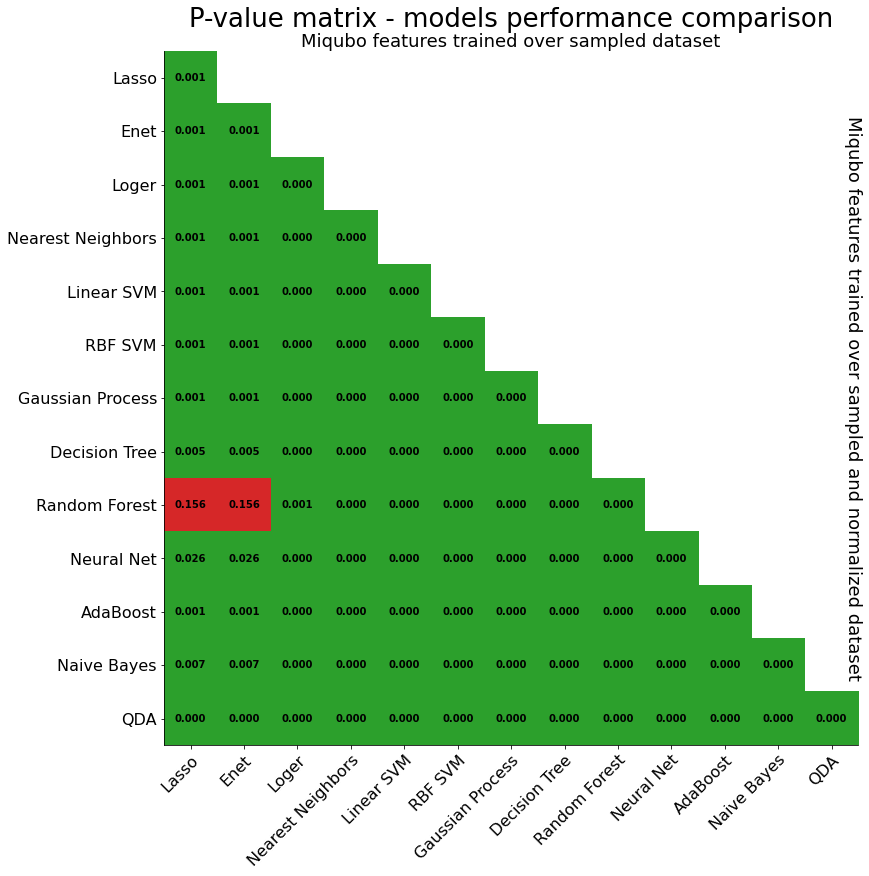

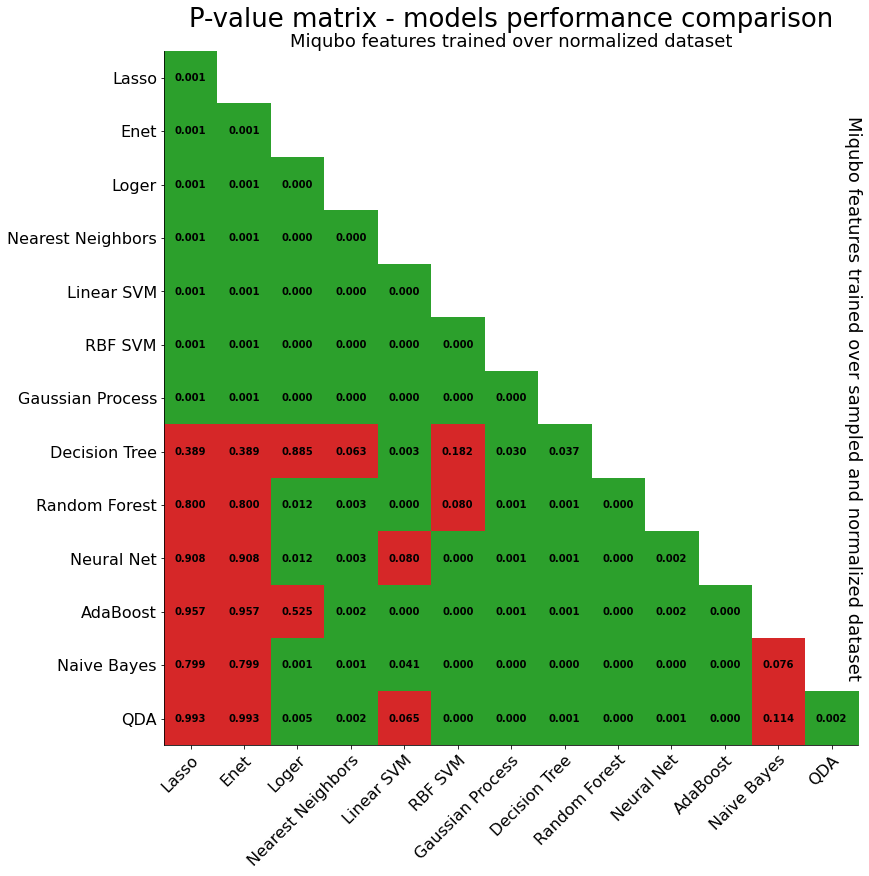

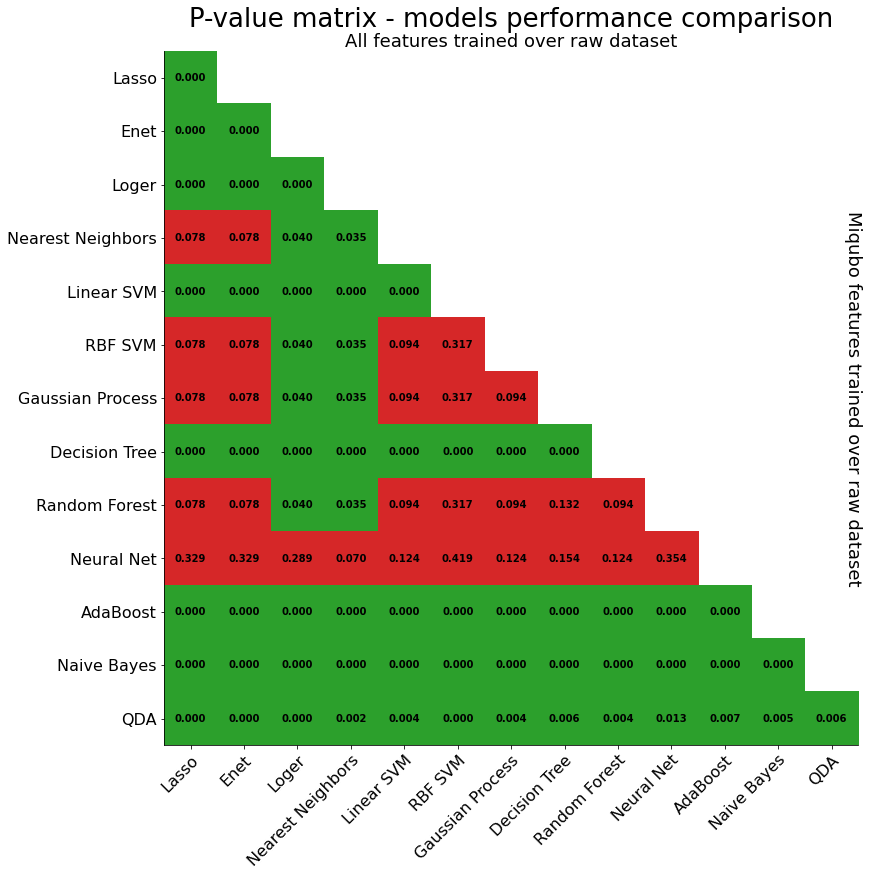

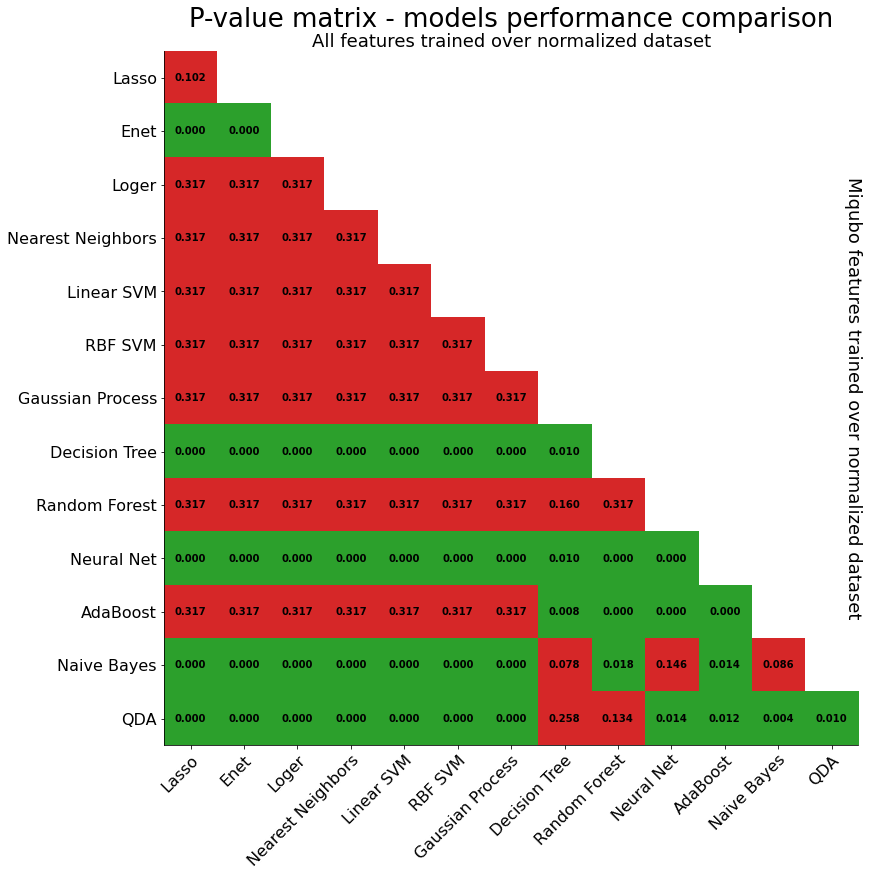

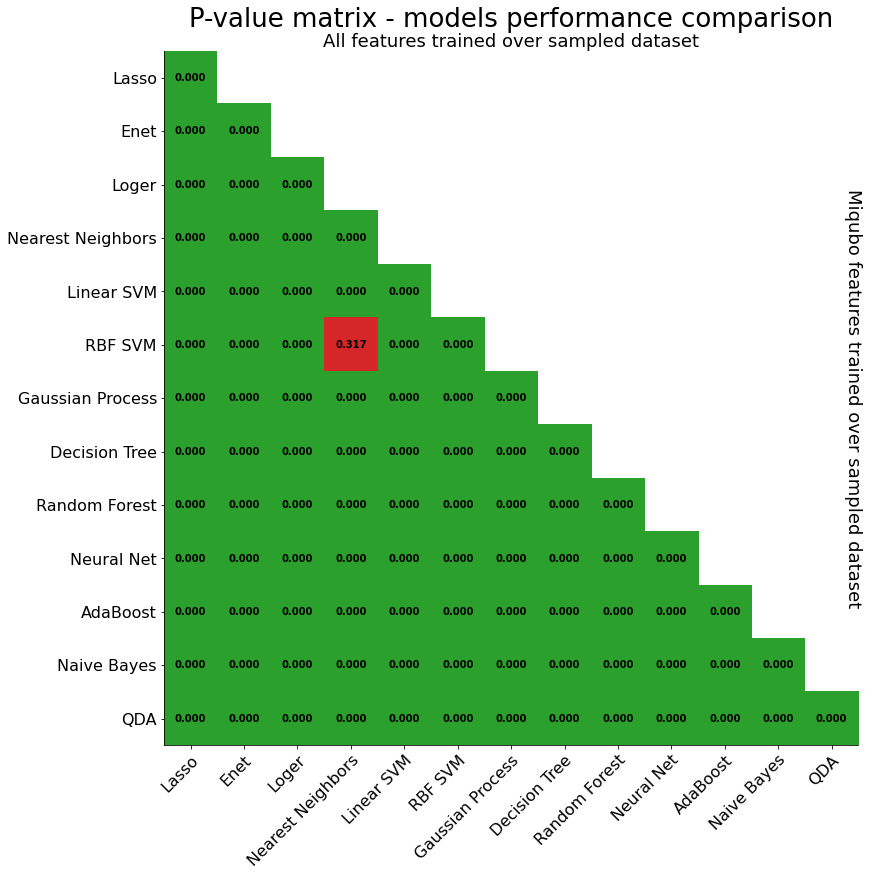

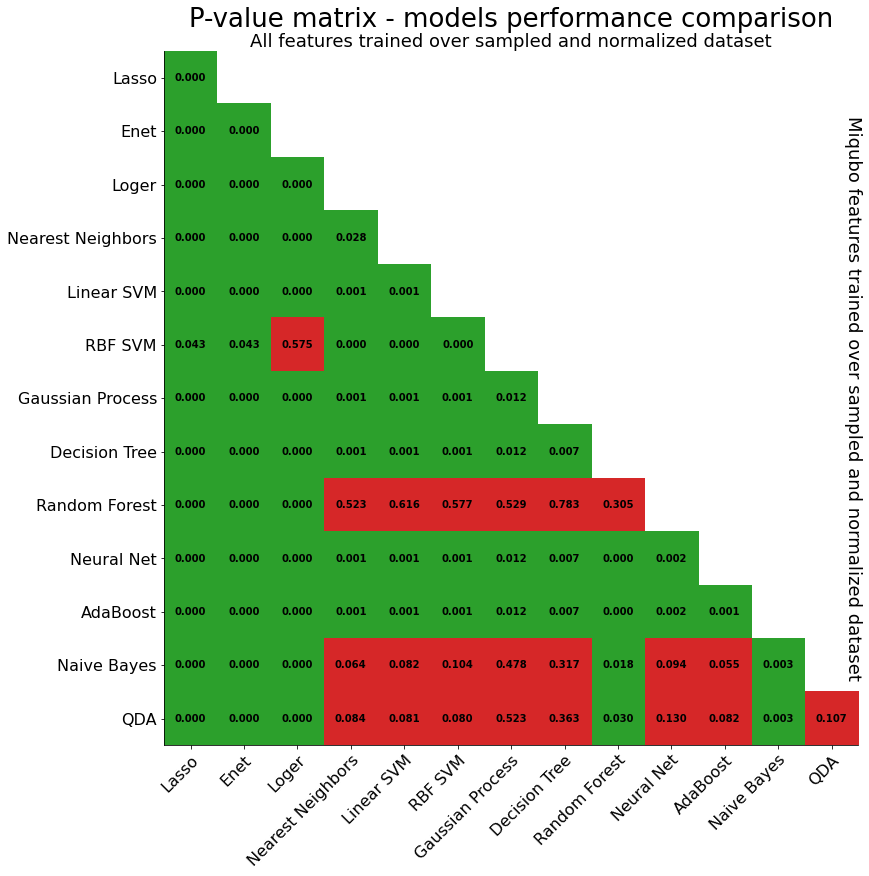

In [126]:

# compare within all class 
_ = get_p_matrix(all_models, all_models_sampled, **{"a_"+ x : y for x, y in raw_all.items()}, **{"b_"+ x : y for x, y in s_all.items()})
_ = get_p_matrix(all_models, all_models_normalized, **{"a_"+ x : y for x, y in raw_all.items()}, **{"b_"+ x : y for x, y in n_all.items()})
_ = get_p_matrix(all_models, all_models_sampled_normalized, **{"a_"+ x : y for x, y in raw_all.items()}, **{"b_"+ x : y for x, y in sn_all.items()})
_ = get_p_matrix(all_models_normalized, all_models_sampled_normalized, **{"a_"+ x : y for x, y in n_all.items()}, **{"b_"+ x : y for x, y in sn_all.items()})
_ = get_p_matrix(all_models_sampled, all_models_sampled_normalized, **{"a_"+ x : y for x, y in s_all.items()}, **{"b_"+ x : y for x, y in sn_all.items()})

# compare within miqubo class 
_ = get_p_matrix(miqubo_models, miqubo_models_sampled, **{"a_"+ x : y for x, y in raw_miqubo.items()}, **{"b_"+ x : y for x, y in s_miqubo.items()})
_ = get_p_matrix(miqubo_models, miqubo_models_normalized, **{"a_"+ x : y for x, y in raw_miqubo.items()}, **{"b_"+ x : y for x, y in n_miqubo.items()})
_ = get_p_matrix(miqubo_models, miqubo_models_sampled_normalized, **{"a_"+ x : y for x, y in raw_miqubo.items()}, **{"b_"+ x : y for x, y in ns_miqubo.items()})
_ = get_p_matrix(miqubo_models_sampled, miqubo_models_sampled_normalized, **{"a_"+ x : y for x, y in s_miqubo.items()}, **{"b_"+ x : y for x, y in ns_miqubo.items()})
_ = get_p_matrix(miqubo_models_normalized, miqubo_models_sampled_normalized, **{"a_"+ x : y for x, y in n_miqubo.items()}, **{"b_"+ x : y for x, y in ns_miqubo.items()})

# compare miqubo to all class
_ = get_p_matrix(all_models, miqubo_models, **{"a_"+ x : y for x, y in raw_all.items()}, **{"b_"+ x : y for x, y in raw_miqubo.items()})
_ = get_p_matrix(all_models_normalized, miqubo_models_normalized, **{"a_"+ x : y for x, y in n_all.items()}, **{"b_"+ x : y for x, y in n_miqubo.items()})
_ = get_p_matrix(all_models_sampled, miqubo_models_sampled, **{"a_"+ x : y for x, y in s_all.items()}, **{"b_"+ x : y for x, y in s_miqubo.items()})
_ = get_p_matrix(all_models_sampled_normalized, miqubo_models_sampled_normalized, **{"a_"+ x : y for x, y in sn_all.items()}, **{"b_"+ x : y for x, y in ns_miqubo.items()})